In [12]:
from matplotlib.pyplot import cm
from matplotlib import colors
from clean import *
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from itertools import product
import scipy.cluster.hierarchy as sch
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
DEBUG = True

In [13]:
df = pd.read_csv('../test_ml/df.csv')

In [14]:
def pca_analysis(data):
    n_components = len(data.columns)

    pca = PCA(n_components=n_components)
    pca.fit(data)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)
    plt.figure(figsize=(12,6))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    plt.show()

def dbscan_param_tuning_silhouette(df_scale):
    eps_values = np.arange(0.2,1.5,0.1) 
    min_samples = np.arange(2,5) 
    dbscan_params = list(product(eps_values, min_samples))
    no_of_clusters = []
    sil_score = []
    epsvalues = []
    min_samp = []

    for p in dbscan_params:
        dbscan_cluster = DBSCAN(eps=p[0], min_samples=p[1]).fit(df_scale)
        epsvalues.append(p[0])
        min_samp.append(p[1])
        if len(np.unique(dbscan_cluster.labels_)) > 1:
            no_of_clusters.append(len(np.unique(dbscan_cluster.labels_)))
            sil_score.append(silhouette_score(df_scale, dbscan_cluster.labels_))

    eps_min = list(zip(no_of_clusters, sil_score, epsvalues, min_samp))
    eps_min_df = pd.DataFrame(eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points'])
    print(eps_min_df)

def pca(n_components, data):
    pca_cols = []
    for i in range(n_components):
        pca_cols.append('pc'+str(i+1))

    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_scale = pca.transform(data)
    pca_df = pd.DataFrame(pca_scale, columns=pca_cols)

    return pca_df

def elbow_method(df):
    df_copy = df.copy()

    nr_clusters = []
    inertias = []
    range_values = np.arange(2,8)

    for k in range_values:
        kmeans = KMeans(k)
        kmeans.fit(df_copy)
        nr_clusters.append(k)
        inertias.append(kmeans.inertia_)

    plt.rcParams.update({'font.size': 22})
    plt.plot(nr_clusters, inertias, "-o", color='#138f8d')
    plt.title('Evolution of Inertia with number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

def silhouette_score(df, labels):
    return metrics.silhouette_score(df, labels, metric='euclidean')

In [15]:
def clustering_kmeans(df, n_clusters=3, init_method='k-means++', n_components=2):
    df_copy = df.copy()

    # Scaling
    scaler = MinMaxScaler()
    scaler.fit(df_copy)
    X_scale = scaler.transform(df_copy)
    df_copy = pd.DataFrame(X_scale, columns=df_copy.columns)

    # Reduce dimensionality with PCA
    if len(df_copy.columns) > 3:
        # Analyse PCA
        if DEBUG:
            pca_analysis(df)
        df_pca = pca(n_components, df)
        if DEBUG:
            elbow_method(df_pca)

        # Compute K-Means
        kmeans = KMeans(n_clusters=n_clusters, init=init_method)
        kmeans.fit_predict(df_pca)
                
        print("KMeans Clusters: \n", Counter(kmeans.labels_))
        print("KMeans Centers: \n", kmeans.cluster_centers_)
        print(f'KMeans Inertia: \n{kmeans.inertia_}')
        print(f'KMeans Silhouette Score: \n{silhouette_score(df_pca, kmeans.labels_)}')

        # Plot results
        if n_components == 2:
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'))
            trace = go.Scatter(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], mode='markers',marker=dict(color = kmeans.labels_, colorscale='bluered', size = 10, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'), zaxis= dict(title  = 'PC3'))
            trace = go.Scatter3d(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], z=df_pca.iloc[:,2], mode='markers',marker=dict(color = kmeans.labels_, colorscale='rainbow', size = 10, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="KMeans Clusters",font=dict(size=16))
        fig.show()

        clusters_pca_scale = pd.concat([df_pca, pd.DataFrame({'cluster':kmeans.labels_})], axis=1)
        cluster_pca_profile = pd.merge(df_copy, clusters_pca_scale['cluster'], left_index=True, right_index=True)

        if DEBUG:
            print(cluster_pca_profile.groupby('cluster').mean())
            print(cluster_pca_profile.groupby('cluster').min())
            print(cluster_pca_profile.groupby('cluster').max())
            print(cluster_pca_profile.groupby('cluster').std())
            
    else:
        if DEBUG:
            elbow_method(df_copy)

        # Compute K-Means
        kmeans = KMeans(n_clusters=n_clusters, init=init_method)
        kmeans.fit_predict(df_copy)

        print("KMeans Clusters: \n", Counter(kmeans.labels_))
        print("KMeans Centers: \n", kmeans.cluster_centers_)
        print(f'KMeans Inertia: \n{kmeans.inertia_}')
        print(f'KMeans Silhouette Score: \n{silhouette_score(df_copy, kmeans.labels_)}')
        print()

        # Plot results
        if len(df_copy.columns) == 2:
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title  = df_copy.columns[1]))
            trace = go.Scatter(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], mode='markers',marker=dict(color=kmeans.labels_, colorscale='rainbow', size = 7, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title = df_copy.columns[1]), zaxis= dict(title = df_copy.columns[2]))
            trace = go.Scatter3d(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], z=df_copy.iloc[:,2], mode='markers',marker=dict(color=kmeans.labels_, colorscale='rainbow', size = 7, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="KMeans Clusters", font=dict(size=16))
        fig.show()

        df_copy.insert(loc=0, column='cluster', value=kmeans.labels_)
        print(df_copy.describe())

In [16]:
def clustering_kmedoids(df, n_clusters=3, init_method='k-medoids++', n_components=2):
    df_copy = df.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(df_copy)
    X_scale = scaler.transform(df_copy)
    df_copy = pd.DataFrame(X_scale, columns=df_copy.columns)
    
    # Reduce dimensionality with PCA
    if len(df_copy.columns) > 3:
        # Analyse PCA
        if DEBUG:
            pca_analysis(df)
        df_pca = pca(n_components, df_copy)
        if DEBUG:
            elbow_method(df_pca)

        # Apply K-Medoids
        kmedoids = KMedoids(n_clusters=n_clusters, method='pam', init=init_method)
        kmedoids.fit(df_pca)
 
        print("\nKMedoids Clusters: \n", Counter(kmedoids.labels_))
        print("KMedoids Centers: \n", kmedoids.cluster_centers_)
        print(f'KMedoids Inertia: \n{kmedoids.inertia_}')
        print(f'KMedoids Silhouette Score: \n{silhouette_score(df_pca, kmedoids.labels_)}')

        # Plot results
        if n_components == 2:
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'))
            trace = go.Scatter(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], mode='markers',marker=dict(color = kmedoids.labels_, colorscale='rainbow', size = 6, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'), zaxis= dict(title  = 'PC3'))
            trace = go.Scatter3d(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], z=df_pca.iloc[:,2], mode='markers',marker=dict(color = kmedoids.labels_, colorscale='rainbow', size = 6, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="KMedoids Clusters",font=dict(size=16))
        fig.show()
    else:
        if DEBUG:
            elbow_method(df_copy)

        # Apply K-Medoids
        kmedoids = KMedoids(n_clusters=n_clusters, method='pam', init=init_method)
        kmedoids.fit_predict(df_copy)

        print("KMedoids Clusters: \n", Counter(kmedoids.labels_))
        print("KMedoids Centers: \n", kmedoids.cluster_centers_)
        print(f'KMedoids Inertia: {kmedoids.inertia_}')
        print(f'KMedoids Silhouette Score: {silhouette_score(df_copy, kmedoids.labels_)}')

        # Plot results
        if len(df_copy.columns) == 2:
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title  = df_copy.columns[1]))
            trace = go.Scatter(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], mode='markers',marker=dict(color=kmedoids.labels_, colorscale='rainbow', size = 7, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title = df_copy.columns[1]), zaxis= dict(title = df_copy.columns[2]))
            trace = go.Scatter3d(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], z=df_copy.iloc[:,2], mode='markers',marker=dict(color=kmedoids.labels_, colorscale='rainbow', size = 7, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="KMedoids Clusters", font=dict(size=16))
        fig.show()

In [17]:
def clustering_dbscan(df, eps=0.9, min_samples=4, n_components=2):
    df_copy = df.copy()

    # Scaling
    scaler = MinMaxScaler()
    scaler.fit(df_copy)
    X_scale = scaler.transform(df_copy)
    df_copy = pd.DataFrame(X_scale, columns=df_copy.columns)

    # Reduce dimensionality with PCA
    if len(df_copy.columns) > 3:
        # Analyse PCA
        if DEBUG:
            pca_analysis(df)
        df_pca = pca(n_components, df)
        if DEBUG:
            dbscan_param_tuning_silhouette(df_pca)

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df_pca)
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f" % silhouette_score(df_pca, labels))

        # Plot results
        labels = dbscan.labels_
        if n_components == 2:
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'))
            trace = go.Scatter(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], mode='markers',marker=dict(color = labels, colorscale='rainbow', size = 6, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'), zaxis= dict(title  = 'PC3'))
            trace = go.Scatter3d(x=df_pca.iloc[:,0], y=df_pca.iloc[:,1], z=df_pca.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='rainbow', size = 6, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="'DBSCAN Clusters Derived from PCA'", font=dict(size=12,))
        fig.show()

    else:
        if DEBUG:
            dbscan_param_tuning_silhouette(df_copy)

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df_copy)
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f" % silhouette_score(df_copy, labels))

        # Plot results
        labels = dbscan.labels_
        if len(df_copy.columns) == 2:
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title  = df_copy.columns[1]))
            trace = go.Scatter(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], mode='markers',marker=dict(color = labels, colorscale='rainbow', size = 7, line = dict(width = 0)))
        else: 
            Scene = dict(xaxis = dict(title = df_copy.columns[0]),yaxis = dict(title = df_copy.columns[1]), zaxis= dict(title = df_copy.columns[2]))
            trace = go.Scatter3d(x=df_copy.iloc[:,0], y=df_copy.iloc[:,1], z=df_copy.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='rainbow', size = 7, line = dict(width = 0)))
        layout = go.Layout(scene = Scene, height = 1000,width = 1000)
        data = [trace]
        fig = go.Figure(data = data, layout = layout)
        fig.update_layout(title="'DBSCAN Clusters'", font=dict(size=12,))
        fig.show()

In [18]:
df.columns

Index(['credit', 'frequency', 'withdrawal', 'credit_amount_avg',
       'withdrawal_amount_avg', 'loan_id', 'amount', 'duration', 'payments',
       'status', 'type', 'gender', 'age_loan', 'unemployment_rate',
       'commited_crimes', 'disp_id_count', 'diff_salary_loan'],
      dtype='object')

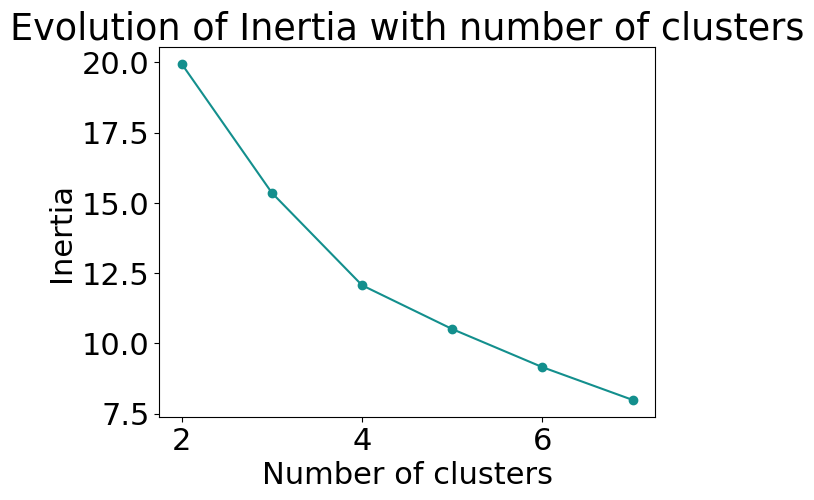

KMeans Clusters: 
 Counter({2: 132, 0: 114, 1: 82})
KMeans Centers: 
 [[0.18610655 0.22068034 0.67471584]
 [0.22346298 0.25003206 0.34554167]
 [0.39808321 0.60399393 0.43279801]]
KMeans Inertia: 
15.358158592127337
KMeans Silhouette Score: 
0.31957324130201736



          cluster  withdrawal_amount_avg  credit_amount_avg  diff_salary_loan
count  328.000000             328.000000         328.000000        328.000000
mean     1.054878               0.280753           0.382279          0.495065
std      0.865605               0.149462           0.221281          0.192151
min      0.000000               0.000000           0.000000          0.000000
25%      0.000000               0.172723           0.210988          0.365712
50%      1.000000               0.259542           0.366599          0.502079
75%      2.000000               0.368849           0.548253          0.615220
max      2.000000               1.000000           1.000000          1.000000


In [34]:
clustering_kmeans(df[['withdrawal_amount_avg','credit_amount_avg','diff_salary_loan']])

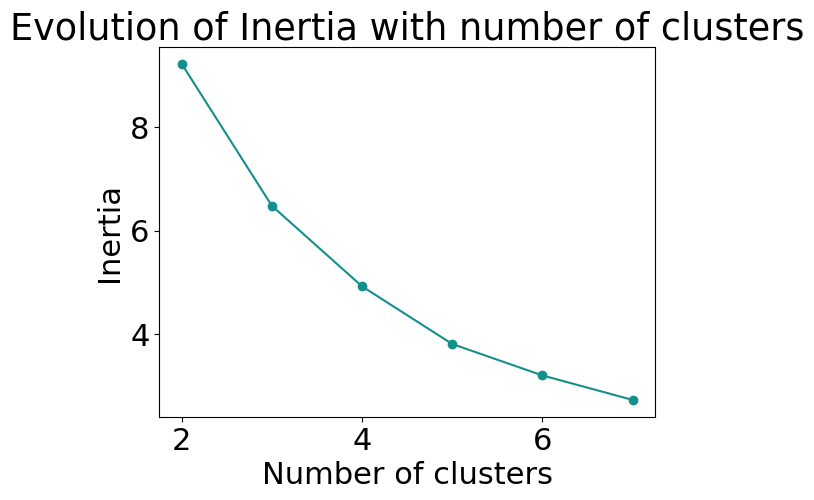

KMedoids Clusters: 
 Counter({0: 121, 1: 104, 2: 103})
KMedoids Centers: 
 [[0.27230361 0.3626615 ]
 [0.13976395 0.1609008 ]
 [0.40424215 0.6366009 ]]
KMedoids Inertia: 38.2305666796166
KMedoids Silhouette Score: 0.4018740691393424


In [27]:
clustering_kmedoids(df[['withdrawal_amount_avg','credit_amount_avg']])

In [31]:
df.columns  



Index(['credit', 'frequency', 'withdrawal', 'credit_amount_avg',
       'withdrawal_amount_avg', 'loan_id', 'amount', 'duration', 'payments',
       'status', 'type', 'gender', 'age_loan', 'unemployment_rate',
       'commited_crimes', 'disp_id_count', 'diff_salary_loan'],
      dtype='object')

In [33]:
clustering_dbscan(df[['credit','frequency']],0.2, 3)

   no_of_clusters  silhouette_score  epsilon_values  minimum_points
0               5          0.607987             0.2               2
1               5          0.607987             0.2               3
2               4          0.607672             0.2               4
3               5          0.607987             0.3               2
4               5          0.607987             0.3               3
5               4          0.607672             0.3               4
6               3          0.623224             0.4               2
7               3          0.623224             0.4               3
8               3          0.623224             0.4               4
Estimated number of clusters: 4
Estimated number of noise points: 2
Silhouette Coefficient: 0.608
